In [1]:
# Import libraries
import matplotlib
import matplotlib.pyplot as plt
from tkinter import Tk, filedialog
import pandas as pd
from IPython import embed
import numpy as np
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from scipy.signal import butter, filtfilt
from scipy.stats import entropy
from scipy import signal
from itertools import islice
import os

In [2]:
# bandpass filter
def butter_bandpass_filter(data, cutofflow, cutoffhigh, fs, order, plot=True):
    nyq = 0.5 * fs  # Nyquist Frequency
    normal_cutofflow = cutofflow / nyq
    normal_cutoffhigh = cutoffhigh / nyq
    # Get the filter coefficients
    b, a = butter(order, [normal_cutofflow, normal_cutoffhigh], btype='band', analog=False)
    if plot is True:
        # plot freq response
        w, h = signal.freqz(b, a)
        fig, ax1 = plt.subplots()
        # ax1.set_title('Bandpass filter frequency response')
        ax1.plot(w*(fs*0.5/np.pi), abs(h), 'b')
        ax1.plot(cutofflow, 0.5*np.sqrt(2), 'go')
        ax1.axvline(cutofflow, color='g',linestyle=':')
        ax1.plot(cutoffhigh, 0.5 * np.sqrt(2), 'go')
        ax1.axvline(cutoffhigh, color='g',linestyle=':')
        ax1.set_title('Bandpass Filter Design')
        ax1.set_ylabel('Magnitude')
        ax1.set_xlabel('Frequency [Hz]')
        plt.show()
    y = filtfilt(b, a, data)
    return y, a, b

# sliding window
def window(seq, n=2):
    "Returns a sliding window (of width n) over data from the iterable"
    "   s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...                   "
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result
    for elem in it:
        result = result[1:] + (elem,)
        yield result

['/recording1', '/recording2', '/recording3']
Recording to be plotted: /recording1


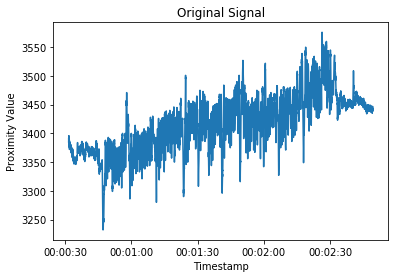

In [3]:
# Ask for file
filename = filedialog.askopenfilename(initialdir=os.getcwd())

# Open file
hdf = pd.HDFStore(filename)
print(hdf.keys())

# Ask for recording id
response = input('Recording to be plotted: ')
dff = hdf.get(response)

# Plot original signal
raw = dff['Proximity']
values = raw[0:]
timestamp = list(values.keys())
plt.plot(timestamp, values)
plt.title(label='Original Signal')
plt.xlabel('Timestamp')
plt.ylabel('Proximity Value')
plt.show()

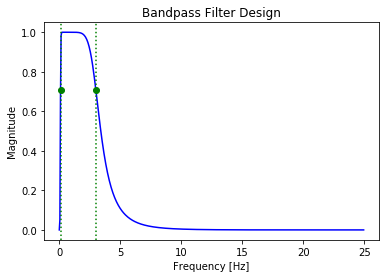

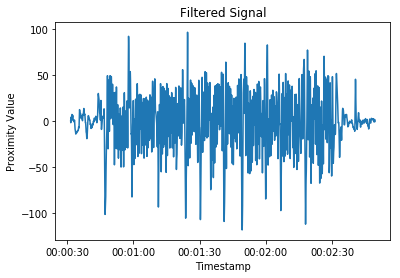

In [4]:
# Perform bandpass filter
fs = 50.0       # sampling rate, Hz
cutoff_1 = 0.1   # desired lower cutoff frequency of the filter, Hz
cutoff_2 = 3.0   # desired higher cutoff frequency of the filter, Hz
order = 4       # fourth-order butterworth filter
filtered_sig, a, b = butter_bandpass_filter(values, cutoff_1, cutoff_2, fs, order)
plt.plot(timestamp, filtered_sig)
plt.title(label='Filtered Signal')
plt.xlabel('Timestamp')
plt.ylabel('Proximity Value')
plt.show()

In [5]:
# chewing detection parameter
ch_start = 0
ch_end = 0
window_size = 50
middle = int(window_size/2)
is_chewing = False
# start of chewing parameter
upper_std_b = 140.0 # fine tuning is necessary
lower_std_b = 26.0 # fine tuning is necessary
d_idx_min = 3
d_idx_max = 2
h_startend_max = 50
# end of chewing parameter
upper_std_e = 15.0 # fine tuning is necessary
queue_size = 150
slide_max = queue_size - window_size + 1
list_plateau = []
plateau_rate_min = 70

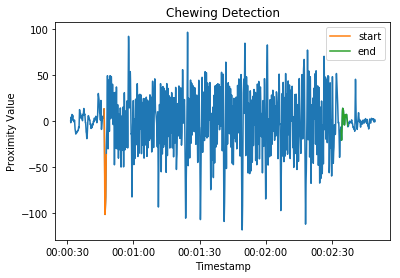

In [6]:
# perform chewing detection
for idx, each in enumerate(window(filtered_sig, window_size)):
    std = np.std(each)
    mean = np.mean(each)
    val_min, idx_min = min((val, idx) for (idx, val) in enumerate(each))
    val_max, idx_max = max((val, idx) for (idx, val) in enumerate(each))
    if is_chewing is False:
        if (lower_std_b < std < upper_std_b) and (each[0] > mean or each[-1] > mean) \
                and (abs(each[0]-each[-1]) < h_startend_max) \
                and (abs(idx_max) <= d_idx_max or abs(idx_max - window_size - 1) <= d_idx_max) \
                and (abs(middle - idx_min) <= d_idx_min):
            ch_start = idx
            is_chewing = True
    else:  # search end of chewing
        if std < upper_std_e :
            list_plateau.append(1)
        else:
            list_plateau.append(0)
        if len(list_plateau) >= slide_max:
            if list_plateau.count(1)*100/slide_max >= plateau_rate_min:
                ch_end = idx
                is_chewing = False
                break
            else:
                del(list_plateau[0])
# Plot the result
plt.plot(timestamp, filtered_sig)
plt.plot(timestamp[ch_start:ch_start + window_size], filtered_sig[ch_start:ch_start + window_size], label='start')
plt.plot(timestamp[ch_end:ch_end + queue_size], filtered_sig[ch_end:ch_end + queue_size], label='end')
plt.title(label='Chewing Detection')
plt.xlabel('Timestamp')
plt.ylabel('Proximity Value')
plt.legend(loc='upper right')
plt.show()
hdf.close()